In [87]:
%matplotlib inline
# %matplotlib qt
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from qutip import *
import random
import time
from mpl_toolkits.mplot3d import Axes3D
import pylab
import matplotlib.animation as animation
from IPython.display import HTML

In [89]:
###
##Functions for autogenerating Hamiltonians
###

op2state = [qeye(2),tensor(create(2),destroy(2))+tensor(destroy(2),create(2))]

class Node:
    
    def __init__(self,ind,coord,pairs):
        self.id = ind
        self.coord = coord
        self.pairs = pairs

theta = np.pi/6

def transform(coord):
    x=coord[1]*np.sin(theta)+coord[0]+ coord[2]*(1/3)*(1+np.sin(theta))
    y=coord[1]*np.cos(theta)         + coord[2]*(1/3)*(np.cos(theta))
    return x,y
        
#Generates an adjacency matrix from a list of pairs 
def genAdjMatrix(dim,nodes):

    matrix = np.array([np.zeros(dim) for i in range(dim)])
    
    for ind, node in nodes.items():
        if node.pairs:
            n1 = node.id
            for pair in node.pairs:
                if str(pair[1]) in nodes:
                    n2 = nodes[str(pair[1])].id
                    w = pair[2]
                    matrix[n1,n2] = w
                    matrix[n2,n1] = w
    return matrix

def tess(x,y,wx,wy,wz):
    return [[[x,y,1],[x+1,y,0],wx],[[x,y,1],[x,y+1,0],wy],[[x,y,1],[x,y,0],wz]]

#Alternating "on" and "off" starting from edge
def genAdj(dim,wx,wy,wz):
    

    nodes = {}
    ydim = dim
    xdim=dim
    for y in range(ydim):
#         for x in range(int(-y/2),dim+int((dim-y)/2)):
        for x in range(xdim):
            nodes[str([x,y,1])] = Node((y*xdim+x)*2,[x,y,1],tess(x,y,wx,wy,wz))
            nodes[str([x,y,0])] = Node((y*xdim+x)*2+1,[x,y,0],None)
   
    for ID,node in nodes.items():
        if node.pairs:
            remove = []
            for pair in node.pairs:
                if not str(pair[1]) in nodes:
                    remove.append(pair)
            for baddies in remove:
                node.pairs.remove(baddies)

    return nodes
        
#Generates a single excitation in a an ensemble of coupled 2 level states
def gen2lvlState(n,states):
    Qobj()
    state = basis(2,states[0])
    for i in range(1,n):
        state =tensor(state,basis(2,states[i]))
    return state

#Generates an observation basis of state number n, with number of exciatations num_states
def genBasisArbitrary(n):
    
    obs_list = [qeye(2),.5*(qeye(2)-sigmaz())]
    observables = {}
    for i in range(n):
        key = "".join(np.array([int(i==j) for j in range(n)]).astype("str"))
        observables[key] = (tensor([obs_list[int(i==j)] for j in range(n)]))
    return observables
     
def adj_to_ham(n): #The row/col of an adj matrix corresponds to Hamiltonian via
    return int(2**(n-1))
    
#Generates a Hamiltonian from an adjacency matrix
def genHamiltonianFromAdjMatrix(adj_matrix):
    print(adj_matrix)
    x = len(adj_matrix)
    dims = [2 for i in range(x)]
    H = 0
    for i in range(x):
        for j in range(i):
            if adj_matrix[i][j]: 
                H+=adj_matrix[i][j]*tensor([op2state[int(j==k)] for k in range(x-1)])
    return H


def plotPath(result,basis_len,ax,tlist):
    results_by_position = result.expect

    global fig
    probs = [[] for i in range(len(tlist)-1)]
    for i in range(len(tlist)-1):
        probs[i] = np.array([value[i] for key, value in results_by_position.items()])
    plt.imshow(probs)
        
def plotTimeIntegral(result,ax,tlist):

    global fig
    probs = np.zeros(len(result.expect))
    for i in range(len(tlist)-1):
        probs += np.array([value[i] for key,value in result.expect.items()])
    probs/=len(tlist)
    plt.imshow([probs])
    
def updateZigZag(i):
    global ax
    global fig
    ax.cla()
    ax = fig.add_subplot(111)
    z_entries = np.array([value[i] for key,value in result.expect.items()])
    plotHeatmap(z_entries,len(z_entries))
    return fig 


def runHamiltonian(num_atoms,state_ind,obs_basis,w1,w2,w3,time,step):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    space_size = 2*num_atoms*(n-1)
    tlist = np.linspace(0,time,step)

    adj_matrix = genAdjMatrix(space_size,genAdj(num_atoms,w1,w2,w3)) 

    H = genHamiltonianFromAdjMatrix(adj_matrix)
    proj = genBasisArbitrary(space_size)

    if obs_basis ==1:
        state = gen2lvlState(space_size,[int(i==state_ind) for i in range(space_size)])
    else:
        arr = [int(i<obs_basis) for i in range(space_size)]
        np.random.shuffle(arr)
        state = gen2lvlState(space_size,arr)

    print("Solving")
    result = sesolve(H,state,tlist,proj)
    plotPath(result,obs_basis,ax,tlist)
#     plotTimeIntegral(result,ax,tlist)
    return H.eigenenergies(),H.eigenstates(),H.groundstate(),proj,result

def plotEigenVector(z,basis,ax,excit):
    if excit>1:
        return
    plt.imshow([z])

def findEigenVectors(eVecs,eVals,o_basis,ax,excit):
    evalsList = []
    for i in range(len(eVecs[1])):
        orth = True
        ket_array = []

        for key,value in o_basis.items():
            if (value*eVecs[1][i]).norm() > 0:
                ket_array.append(np.real((value*eVecs[1][i]).norm()))
        if np.sum(ket_array)>0.01:
            evalsList.append(eVals[i])
            plotEigenVector(ket_array,o_basis,ax,excit)
            print(eVals[i])
            plt.show()
            ax.cla()
    return evalsList

def COBMatrixGenerator(n):
    init_list=[[0 for i in range(n)]]
    for i in range(n):
        init_list.append([int(i==(n-j-1)) for j in range(n)])
    start_basis = init_list.copy()
    for m in range(n-1): #We want n particles per state
        size = len(start_basis)   #We copy the size of the previous list to add new particles
        for elem in start_basis:
            for j in range(n):
                if elem[j] != 1:
                    temp_list = elem.copy()
                    temp_list[j]=1
                    if not temp_list in start_basis:
                        start_basis.append(temp_list)
    size = len(start_basis)
    end_basis = start_basis.copy()
    end_basis.sort()
    map_list = [end_basis.index(basis) for basis in start_basis]
    COB_mat = np.mat([[int(i == map_list[j]) for j in range(size)] for i in range(size)])
    return COB_mat

def reduceBlockDiagonalHamiltonian(H,n,pn,): #Reduces BD Hamiltonian to some particle number basis
    COB = COBMatrixGenerator(int((np.log(H.shape)/np.log(2))[0]))
    COBinv = Qobj(np.linalg.inv(COB), dims = H.dims, shape = H.shape)
    print("Generated COB inverse matrix")
    COB = Qobj(COB, dims = H.dims, shape = H.shape)
    print("Generated COB matrix")
    diag_mat = COBinv*H*COB
    print(diag_mat)
    print("Block diagonalized Hamiltonian")
    indices = [sp.special.comb(n,p) for p in range(pn+1)]
    print(indices)
    l_bound = int(np.sum(indices[:-1]))
    r_bound = int(l_bound+indices[pn])
    mat_red = [[diag_mat[i][0][j] for i in range(l_bound,r_bound)] for j in range(l_bound,r_bound)]
    H_red = Qobj(mat_red,shape = [[r_bound-l_bound]for i in range(2)])
    return H_red

[0, 0, 1] 0
[0, 0, 0] 1
[1, 0, 1] 2
[1, 0, 0] 3
[0, 1, 1] 4
[0, 1, 0] 5
[1, 1, 1] 6
[1, 1, 0] 7


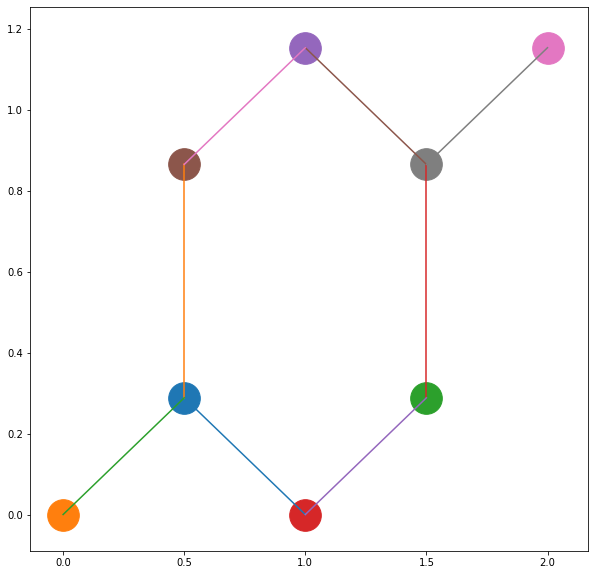

In [32]:
n=2
fig = plt.figure(figsize=(10,10))
for key,val in genAdj(n,1,1,1).items():
    if val.pairs:
        for adj in val.pairs:
            p1 = transform(adj[0])
            p2 = transform(adj[1])
            plt.plot([p1[0],p2[0]],[p1[1],p2[1]])
    print(key, val.id)


    x,y = transform(val.coord)
    plt.scatter(x,y,s=1000)
plt.show()

In [86]:
n=2
H=genHamiltonianFromAdjMatrix(genAdjMatrix(2*n**2,genAdj(n,1,1,1)))
H

[[0. 1. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0.]]


Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2]], shape = (256, 256), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [51]:
H_red = reduceBlockDiagonalHamiltonian(H,2*n**2,1)
H_red

Generated COB inverse matrix
Generated COB matrix
Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2]], shape = (256, 256), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 3.]
 [0. 0. 0. 0. 0. 0. 3. 0.]]

In [25]:
H

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape = (262144, 262144), type = oper, isherm = True
Qobj data =
  (2, 4)	(3+0j)
  (3, 5)	(3+0j)
  (4, 2)	(3+0j)
  (4, 8)	(1+0j)
  (5, 3)	(3+0j)
  (5, 9)	(1+0j)
  (6, 10)	(1+0j)
  (7, 11)	(1+0j)
  (8, 4)	(1+0j)
  (8, 16)	(2+0j)
  (9, 5)	(1+0j)
  (9, 17)	(2+0j)
  (10, 6)	(1+0j)
  (10, 12)	(3+0j)
  (10, 18)	(2+0j)
  (11, 7)	(1+0j)
  (11, 13)	(3+0j)
  (11, 19)	(2+0j)
  (12, 10)	(3+0j)
  (12, 20)	(2+0j)
  (13, 11)	(3+0j)
  (13, 21)	(2+0j)
  (14, 22)	(2+0j)
  (15, 23)	(2+0j)
  (16, 8)	(2+0j)
  :	:
  (262127, 262135)	(2+0j)
  (262128, 262120)	(2+0j)
  (262129, 262121)	(2+0j)
  (262130, 262122)	(2+0j)
  (262130, 262132)	(3+0j)
  (262131, 262123)	(2+0j)
  (262131, 262133)	(3+0j)
  (262132, 262124)	(2+0j)
  (262132, 262130)	(3+0j)
  (262132, 262136)	(1+0j)
  (262133, 262125)	(2+0j)
  (262133, 262131)	(3+0j)
  (262133, 262137)	(1+0j)
  (262134, 262126)	(2+0j)
 

In [261]:
mat = COBMatrixGenerator(3)
mat_inv = np.linalg.inv(mat)
print(mat)
print(mat_inv)

[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1]]
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [16]:
n=2
H=genHamiltonianFromAdjMatrix(genAdjMatrix(2*n**2,genAdj(n,1,1,1)))

H=genHamiltonianFromAdjMatrix(genAdjMatrix(2*n**2,genAdj(n,1,1,1)))
mat = reduceBlockDiagonalHamiltonian(H,2*n**2,6)
mat

Quantum object: dims = [[28], [28]], shape = (28, 28), type = oper, isherm = True
Qobj data =
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [1. 0. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 2. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 2. 0. 0. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 2. 2. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 2. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 2. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 2. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0.

In [38]:
op2state

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[1. 0.]
  [0. 1.]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[0. 0. 0. 0.]
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [0. 0. 0. 0.]]]

In [77]:
n=2
H=genHamiltonianFromAdjMatrix(genAdjMatrix(2*n**2,genAdj(n,1,1,1)))
COB = COBMatrixGenerator(int((np.log(H.shape)/np.log(2))[0]))
COBinv = Qobj(np.linalg.inv(COB), dims = H.dims, shape = H.shape)
COB = Qobj(COB, dims = H.dims, shape = H.shape)
COBinv*H*COB

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2]], shape = (256, 256), type = oper, isherm = True
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

In [74]:
H

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2]], shape = (256, 256), type = oper, isherm = True
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]